# Implementación de un modelo atmosférico.
En este notebook haremos un análisis sobre la resolución de un sistema de ecuaciones diferenciales parciales (EDP).

\begin{align*}
\partial_{t}\left(\omega\right)-\left(b\left(z,t\right)-\dfrac{\omega}{\tau_{w}}\right) & =0\\
\partial_{t}\left(\theta\right)+\partial_{z}\left(\omega\theta\right) & =0\\
\partial_{t}\left(q_{v}\right)+\partial_{z}\left(\omega q_{v}\right) & =0\\
\partial_{t}\left(q_{r}\right)+\partial_{z}\left(\left(\omega-V_{\text{T}}\right)q_{r}\right) & =0\\
\partial_{t}\left(q_{N}\right)+\partial_{z}\left(\left(\omega-V_{\text{TN}}\right)q_{N}\right) & =0
\end{align*}

Para luego, agregarle un ruido blanco, mediante el movimiento browiano. $W_t$
## Variables principales.
Este modelo es una versión del modelo FARE (Fast Autoconvection Rain Evaporation). En el cual se mencionan 5 funciones principales.

\begin{align*}
\omega & :\text{Velocidad vertical }\left(\dfrac{\text{m}}{\text{s}}\right)\\
\theta & :\text{Temperatura potencial }\left(\dfrac{\text{m}}{\text{s}}\right)\\
q_{v} & :\text{Proporción de vapor de agua }\left(\dfrac{\text{g}}{\text{Kg}}\right)\\
q_{r} & :\text{Proporción de agua líquida }\left(\dfrac{\text{g}}{\text{Kg}}\right)\\
q_{N} & :\text{Proporción de núcleos de condensación }\left(\dfrac{\text{g}}{\text{Kg}}\right)
\end{align*}

# Implementación Númerica
Por lo general, los EDP no pueden resolverse de forma analítica, por lo tanto recurriremos a métodos numéricos para resolverlos. Para aquello, iremos navengando por los siguientes pasos. 

1. Adimensionalización
2. Implementación
3. Resultados

Todo esto dentro del lenguaje de Python. 

## Adimensionalizacion
La adimensionalizacion consta de eliminar las unidades físicas de cierta cantidad mediante operaciones básicas, para aquello, primero debemos definir ciertas constantes, a las que llamaremos escalas. Estan serán fijas y permitiran una transformación consistente. 

In [ ]:
import parameters as p

1000.0


Las lineas 3 a 7 del archivo parameters.py, son las escalas que utilizaremos. Una por cada variable fundamental más una auxiliar (la de la velocidad), asi por ejemplo, la gravedad esta dada por 9.81 $m/s$, entonces en nuestro sistema adimensional.

$$g' = \dfrac{g}{\text{Vs}}$$

, y cuando ocupemos recuperar la información, solo hacemos la operacion contraria $g = (g')(Vs) $. 

En el resto del archivo están la mayoría de parámetros ya adimensionales.
## Implementacion (Zona de trabajo)
Ahora incorporamos las librerias de Python básicas. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Primero, definiremos la zona de trabajo, en este caso nuestas funciones son multivariable, es decir $\omega\equiv\omega(z,t)$, donde $z$ está en km y el tiempo en minutos. En nuestro sistema, consideraremos la tropopausa como limite superior, entonces $z_0 = 0$ Km y $z = 15$Km 

In [ ]:
z_0 = 0
z_f = 15 
z_0 = z_0 / p.length_scale  # No olvidemos adimensionalizar
z_f = z_f / p.length_scale

Para el tiempo, consideremos la cuenta hasta los $t$ minutos, es decir, $t_0 = 0$ y $T = t$ en minutos. 

In [ ]:
t_0 = 0
t_f = 2
t_0 = t_0 / p.time_scale
t_f = t_f / p.time_scale

Luego, definimos la "malla", es decir una matriz de $m \times n$, donde cada columna es un instante de tiempo y cada renglon una altura.

$$M_{ij}=(z_i,t_j); 0\leq i\leq m, 0\leq j \leq n$$

, aquí $m,n$ definiran el "grosor" de la malla, a $m,n$ más grandes, más fina sera la malla. 

In [ ]:
nz = 150 # Esta es nuesta m 
space = np.linspace(z_0,z_f,nz)
dz = space[1] - space[0]

Otra forma de "medir" el grosor de la malla es $\Delta z$, mientras más pequeño, más fina es la malla. En nuestro caso no definiremos el número de columnas, esto porque $\Delta t = f(\cdot,\Delta t)$, es decir, ira evolucionado a lo largo de la simulación. Esa evolución vendrá dada por el Número de Courant-Friedrichs-Levy (CFL).

$$\text{CFL}=\dfrac{c_0 \Delta t}{\Delta z}$$

, donde $c_0$ depende del sistema a resolver y no es necesariamente constante. Más adelante retomaremos para definir $c_0$ en nuestro sistema.

## Implementacion (Condiciones iniciales)
Para nuestro problema, partiremos de funciones escalonadas, tambien conocidas como función de Heaviside

$$U\left(x\right)=\begin{cases}
0 & x<0\\
1 & x\geq 0
\end{cases}$$

In [ ]:
def heaviside(x):
    if x < 0:
        y = 0
    else:
        y = 1
    return y

Con ella, construiremos cada una de las condiciones iniciales de las funciones.

\begin{align*}
\omega_{0}\left(z,0\right) & =U\left(z-3\right)\\
\theta_{0}\left(z,0\right) & =U\left(z-3\right)\\
q_{v,0}\left(z,0\right) & =U\left(z-3\right)\\
q_{r,0}\left(z,0\right) & =U\left(z-3\right)\\
q_{N,0}\left(z,0\right) & =U\left(z-3\right)
\end{align*}

In [8]:
cut_omega = 3 
cut_theta = 3
cut_qv = 3
cut_qr = 3
cut_qn = 3

cut_omega = cut_omega / p.length_scale  # No olvidemos adimensionalizar
cut_theta = cut_theta / p.length_scale
cut_qv = cut_qv / p.length_scale
cut_qr = cut_qr / p.length_scale
cut_qn = cut_qn / p.length_scale

Ahora, como prueba graficaremos $\theta_0$. 

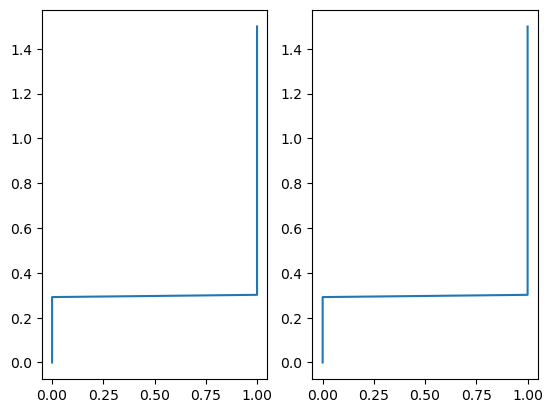

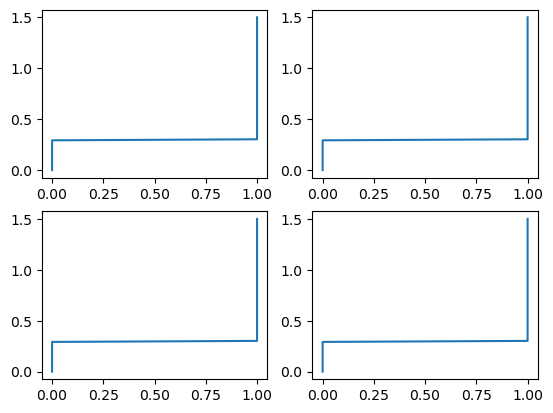

In [10]:
wt_plots, ax = plt.subplots(1, 2)
qvrn_plots, axq = plt.subplots(2,2)
ax[0].plot([heaviside(i - cut_omega) for i in space],space)
ax[1].plot([heaviside(i - cut_theta) for i in space],space)

axq[0,0].plot([heaviside(i - cut_omega) for i in space],space)
axq[0,1].plot([heaviside(i - cut_qv) for i in space],space)
axq[1,0].plot([heaviside(i - cut_qr) for i in space],space)
axq[1,1].plot([heaviside(i - cut_qn) for i in space],space)

Para el resto del trabajo, usaremos la siguiente función. La que nos permitirá graficar de una forma más sencilla. 

In [11]:
def system_plots(velocity,temperature,vapor,water,core):
    wt_plots, ax = plt.subplots(1, 2)
    qvrn_plots, axq = plt.subplots(2,2)
    ax[0].plot(velocity * p.velocity_scale,space * p.length_scale)
    ax[1].plot(temperature * p.temperature_scale,space * p.length_scale)
    axq[0,0].plot(velocity * p.velocity_scale,space * p.length_scale)
    axq[0,1].plot(vapor * p.ratio_scale,space * p.length_scale)
    axq[1,0].plot(water * p.ratio_scale,space * p.length_scale)
    axq[1,1].plot(core * p.ratio_scale,space * p.length_scale)
    plt.show()

Entonces, construimos la zona de trabajo. Es decir, el espacio dedicado a guardar el comportamiento del sistema a lo largo del tiempo. Esta será una matriz de $nz\times 5$. Esto porque debe almacenar las 5 variables en cada punto de la partición de la altura $[0,15]$.

In [12]:
workspace = np.zeros((nz,5))
# Columna 0, Velocidad
# Columna 1, Temperatura potencial
# Columna 2, Vapor de agua
# Columna 3, Agua Líquida
# Columna 4, Núcleos de Condensación

Ahora, procedemos con la resolución del sistema, para ello, fijaremos la velocidad $\omega(z,t)=-1,\forall z\in [0,15],t\in\mathbb{R}^{+}$.

In [13]:
workspace[:, 0] = -1
workspace[:, 1] = [heaviside(i - cut_theta) for i in space]
workspace[:, 2] = [heaviside(i - cut_qv) for i in space]
workspace[:, 3] = [heaviside(i - cut_qr) for i in space]
workspace[:, 4] = [heaviside(i - cut_qn) for i in space]

Realizando una prueba, graficando cada uno de las columnas de workspace.

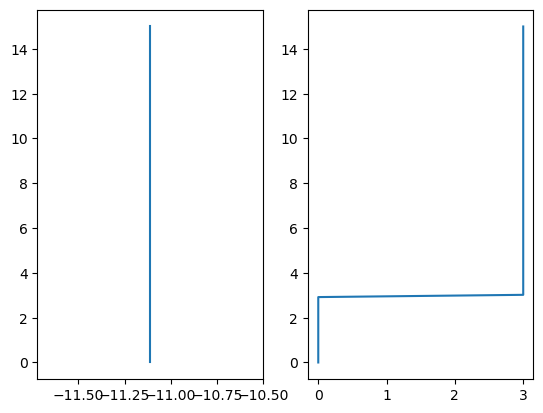

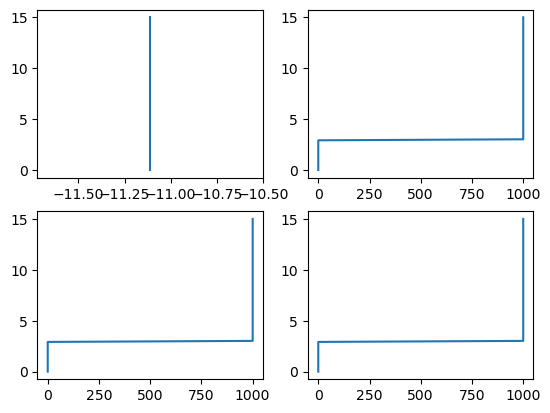

In [14]:
system_plots(workspace[:,0],workspace[:,1],workspace[:,2],workspace[:,3],workspace[:,4])

Entonces, redefinimos la función para graficar, aprovechando la forma de workspace.

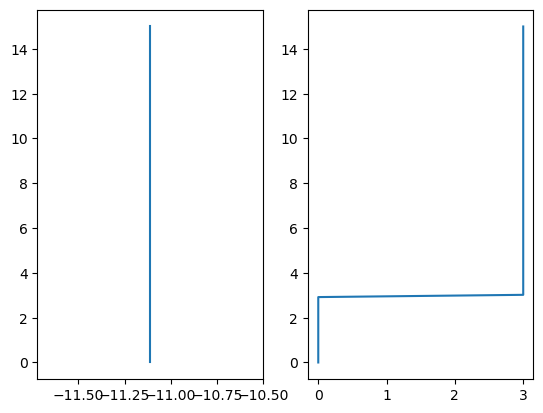

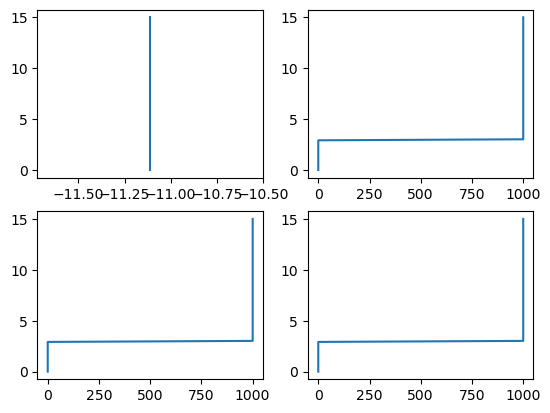

In [15]:
def workspace_plots(wspace):
    system_plots(wspace[:,0],wspace[:,1],wspace[:,2],wspace[:,3],wspace[:,4])
workspace_plots(workspace)

Ahora, comenzamos con la solución, para ello, retomemos el sistema visto al comienzo. 
\begin{align*}
\partial_{t}\left(\omega\right)-\left(b\left(z,t\right)-\dfrac{\omega}{\tau_{w}}\right) & =0\\
\partial_{t}\left(\theta\right)+\partial_{z}\left(\omega\theta\right) & =0\\
\partial_{t}\left(q_{v}\right)+\partial_{z}\left(\omega q_{v}\right) & =0\\
\partial_{t}\left(q_{r}\right)+\partial_{z}\left(\left(\omega-V_{\text{T}}\right)q_{r}\right) & =0\\
\partial_{t}\left(q_{N}\right)+\partial_{z}\left(\left(\omega-V_{\text{TN}}\right)q_{N}\right) & =0
\end{align*}

Como $\omega\equiv -1$, entonces el sistema queda como sigue

\begin{align*}
\omega(z,t) & =-1\\
\partial_{t}\left(\theta\right)-\partial_{z}\left(\theta\right) & =0\\
\partial_{t}\left(q_{v}\right)-\partial_{z}\left(q_{v}\right) & =0\\
\partial_{t}\left(q_{r}\right)-\partial_{z}\left(\left(1+V_{\text{T}}\right)q_{r}\right) & =0\\
\partial_{t}\left(q_{N}\right)-\partial_{z}\left(\left(1+V_{\text{TN}}\right)q_{N}\right) & =0
\end{align*}

Definimos $V_{\text{T}},V_{\text{TN}}$

In [16]:
def get_terminalvelocity(r):
    y = r/1000
    return y

def get_aerosolvelocity(r):
    y = r/1000
    return y

Ya con todas las funciones terminadas, procedemos a resolver el sistema de ecuaciones, para eso usaremos las diferencias finifas, por ejemplo, para $\theta$
$$\partial_t(\theta)-\partial_z(\theta)=0$$, sustituyendo las derivadas parciales, por los cocientes diferenciales tenemos lo siguiente.
\begin{align*}
\dfrac{\theta\left(z,t+\Delta t\right)-\theta\left(z,t\right)}{\Delta t} & =\dfrac{\theta\left(z+\Delta z,t\right)-\theta\left(z,t\right)}{\Delta z}\\
\theta\left(z,t+\Delta t\right) & =\theta\left(z,t\right)+\dfrac{\Delta t}{\Delta z}\left[\theta\left(z+\Delta z,t\right)-\theta\left(z,t\right)\right]
\end{align*}
Esto lo haremos para cada función, y tendremos lo siguiente
\begin{align*}
\theta\left(z,t+\Delta t\right) & =\theta\left(z,t\right)+\dfrac{\Delta t}{\Delta z}\left[\theta\left(z+\Delta z,t\right)-\theta\left(z,t\right)\right]\\
q_{v}\left(z,t+\Delta t\right) & =q_{v}\left(z,t\right)+\dfrac{\Delta t}{\Delta z}\left[q_{v}\left(z+\Delta z,t\right)-q_{v}\left(z,t\right)\right]\\
q_{r}\left(z,t+\Delta t\right) & =q_{r}\left(z,t\right)+\dfrac{\Delta t}{\Delta z}\left[\left(1+V_{T}\left(q_{r}\left(z+\Delta z\right)\right)\right)q_{r}\left(z+\Delta z,t\right)-\left(1+V_{T}\left(q_{r}\left(z\right)\right)\right)q_{r}\left(z,t\right)\right]\\
q_{N}\left(z,t+\Delta t\right) & =q_{N}\left(z,t\right)+\dfrac{\Delta t}{\Delta z}\left[\left(1+V_{TN}\left(q_{r}\left(z+\Delta z\right)\right)\right)q_{N}\left(z+\Delta z,t\right)-\left(1+V_{TN}\left(q_{r}\left(z+\Delta z\right)\right)\right)q_{N}\left(z,t\right)\right]
\end{align*}
Considerando que $i$ corresponde al espacio y $j$ al tiempo, tenemos el sistema de forma más compacta

In [17]:
def one_sided_v1(dt, dz, u, v0):
    m = np.shape(u)[0]
    aux = np.zeros((m,5))
    dzt = dt / dz
    vel = u[:,0]
    tem = u[:,1]
    qv = u[:,2]
    qr = u[:,3]
    qn = u[:,4]
    for i in range(1,m-1):
        aux[i, 0] = v0
        aux[i, 1] = tem[i] - dzt * v0 * (tem[i + 1] - tem[i]) 
        aux[i, 2] = qv[i] - dzt * v0 * (qv[i + 1] - qv[i])
        aux[i, 3] = qr[i] - dzt * v0 * (qr[i + 1] - qr[i])
        aux[i, 4] = qn[i] - dzt * v0 * (qn[i + 1] - qn[i])
        aux[0, :] = aux[1, :]
        aux[-1,:] = aux[-2, :]
    return aux

Entonces, hacemos la prueba. Por lo tanto, debemos definir $\Delta t$

In [18]:
cfl = 0.9
dt = cfl * dz / np.max(np.abs(workspace))

# v_test = -1
# while t_0 < t_f:
#    workspace = one_sided_v1(dt,dz, workspace,v_test)
#    dt = cfl * dz
#    t_0 += dt

Para corregir este problema, debemos modificar la función que calcula la solución, mediante un criterio de estabilidad.

In [19]:
def one_sided_v2(dt, dz, u, v0):
    m = np.shape(u)[0]
    aux = np.zeros((m,5))
    dzt = dt / dz
    vel = u[:,0]
    tem = u[:,1]
    qv = u[:,2]
    qr = u[:,3]
    qn = u[:,4]
    for i in range(1,m-1):
        if v0 < 0:
            aux[i, 0] = v0
            aux[i, 1] = tem[i] - dzt * v0 * (tem[i + 1] - tem[i]) 
            aux[i, 2] = qv[i] - dzt * v0 * (qv[i + 1] - qv[i])
            aux[i, 3] = qr[i] - dzt * v0 * (qr[i + 1] - qr[i])
            aux[i, 4] = qn[i] - dzt * v0 * (qn[i + 1] - qn[i])
        else:
            aux[i, 0] = v0
            aux[i, 1] = tem[i] - dzt * v0 * (tem[i] - tem[i - 1]) 
            aux[i, 2] = qv[i] - dzt * v0 * (qv[i] - qv[i - 1])
            aux[i, 3] = qr[i] - dzt * v0 * (qr[i] - qr[i - 1])
            aux[i, 4] = qn[i] - dzt * v0 * (qn[i] - qn[i - 1])
        aux[0, :] = aux[1, :]
        aux[-1,:] = aux[-2, :]
    return aux

Ahora, reintentando veremos que el sistema funciona, sin embargo, aun falta agregar las funciones $V_\text{T},V_{\text{TN}}$

In [20]:
def one_sided_v3(dt, dz, u, v0):
    m = np.shape(u)[0]
    aux = np.zeros((m,5))
    dzt = dt / dz
    vel = u[:,0]
    tem = u[:,1]
    qv = u[:,2]
    qr = u[:,3]
    qn = u[:,4]
    for i in range(1,m-1):
        if v0 < 0:
            aux[i, 0] = v0
            aux[i, 1] = tem[i] - dzt * v0 * (tem[i + 1] - tem[i]) 
            aux[i, 2] = qv[i] - dzt * v0 * (qv[i + 1] - qv[i])
            aux[i, 3] = qr[i] - dzt * ((v0 - get_terminalvelocity(qr[i + 1])) * qr[i + 1] - (v0 - get_terminalvelocity(qr[i])) * qr[i])
            aux[i, 4] = qn[i] - dzt * v0 * (qn[i + 1] - qn[i])
        else:
            aux[i, 0] = v0
            aux[i, 1] = tem[i] - dzt * v0 * (tem[i] - tem[i - 1]) 
            aux[i, 2] = qv[i] - dzt * v0 * (qv[i] - qv[i - 1])
            aux[i, 3] = qr[i] - dzt * ((v0 - get_terminalvelocity(qr[i])) * qr[i] - (v0 - get_terminalvelocity(qr[i - 1])) * qr[i - 1])
            aux[i, 4] = qn[i] - dzt * v0 * (qn[i] - qn[i - 1])
        aux[0, :] = aux[1, :]
        aux[-1,:] = aux[-2, :]
    return aux

In [21]:
def resol_test1(t_0, t_f, dt, dz, v_test, workspace):    
    while t_0 < t_f:
        workspace = one_sided_v3(dt,dz, workspace,v_test)
        dt = cfl * dz
        t_0 += dt
    workspace_plots(workspace)
    return workspace

In [22]:
# print(resol_test(t_0, t_f, dt, dz, -1, workspace))

In [23]:
def one_sided_v4(dt, dz, u, v0):
    m = np.shape(u)[0]
    aux = np.zeros((m,5))
    dzt = dt / dz
    vel = u[:,0]
    tem = u[:,1]
    qv = u[:,2]
    qr = u[:,3]
    qn = u[:,4]
    for i in range(1,m-1):
        if v0 < 0:
            aux[i, 0] = v0
            aux[i, 1] = tem[i] - dzt * v0 * (tem[i + 1] - tem[i]) 
            aux[i, 2] = qv[i] - dzt * v0 * (qv[i + 1] - qv[i])
            aux[i, 3] = qr[i] - dzt * ((v0 - get_terminalvelocity(qr[i + 1])) * qr[i + 1] - (v0 - get_terminalvelocity(qr[i])) * qr[i])
            aux[i, 4] = qn[i] - dzt * ((v0 - get_aerosolvelocity(qr[i + 1])) * qn[i + 1] - (v0 - get_aerosolvelocity(qr[i + 1])) * qn[i])
        else:
            aux[i, 0] = v0
            aux[i, 1] = tem[i] - dzt * v0 * (tem[i] - tem[i - 1]) 
            aux[i, 2] = qv[i] - dzt * v0 * (qv[i] - qv[i - 1])
            aux[i, 3] = qr[i] - dzt * ((v0 - get_terminalvelocity(qr[i])) * qr[i] - (v0 - get_terminalvelocity(qr[i - 1])) * qr[i - 1])
            aux[i, 4] = qn[i] - dzt * ((v0 - get_aerosolvelocity(qr[i + 1])) * qn[i] - (v0 - get_aerosolvelocity(qr[i + 1])) * qn[i - 1])
        aux[0, :] = aux[1, :]
        aux[-1,:] = aux[-2, :]
    return aux

In [24]:
# print(resol_test(t_0, t_f, dt, dz, -1, workspace))

Entonces, procedemos a agregar las funciones $V_{\text{T}},V_{\text{TN}}$ del modelo original. Para ello vamos a importarlas. 

In [25]:
import atmosmodel as atm

In [38]:
def one_sided_v5(dt, dz, u, v0,vpar2):
    m = np.shape(u)[0]
    aux = np.zeros((m,5))
    dzt = dt / dz
    vt0 = vpar2[0]
    vtnd =vpar2[1]
    q_star = vpar2[2]
    vel = u[:,0]
    tem = u[:,1]
    qv = u[:,2]
    qr = u[:,3]
    qn = u[:,4]
    for i in range(1,m-1):
        if v0 < 0:
            aux[i, 0] = v0
            aux[i, 1] = tem[i] - dzt * v0 * (tem[i + 1] - tem[i]) 
            aux[i, 2] = qv[i] - dzt * v0 * (qv[i + 1] - qv[i])
            aux[i, 3] = (qr[i] - dzt * 
                         ((v0 - atm.get_terminalvelocity(vt0, qr[i + 1], q_star)) * qr[i + 1] - (v0 - atm.get_terminalvelocity(vt0, qr[i],q_star)) * qr[i]))
            aux[i, 4] = (qn[i] - dzt * 
                         ((v0 - atm.get_aerosolvelocity(vtnd, vt0, qr[i + 1], q_star)) * qn[i + 1] - (v0 - atm.get_aerosolvelocity(vtnd,vt0,qr[i],q_star)) * qn[i]))
        else:
            aux[i, 0] = v0
            aux[i, 1] = tem[i] - dzt * v0 * (tem[i] - tem[i - 1]) 
            aux[i, 2] = qv[i] - dzt * v0 * (qv[i] - qv[i - 1])
            aux[i, 3] = (qr[i] - dzt * 
                         ((v0 - atm.get_terminalvelocity(vt0, qr[i], q_star)) * qr[i] - (v0 - atm.get_terminalvelocity(vt0, qr[i - 1],q_star)) * qr[i - 1]))
            aux[i, 4] = (qn[i] - dzt * 
                         ((v0 - atm.get_aerosolvelocity(vtnd, vt0, qr[i], q_star)) * qn[i] - (v0 - atm.get_aerosolvelocity(vtnd, vt0, qr[i - 1],q_star)) * qn[i - 1]))
       # Antes de cambiarlo, funciona.
        aux[0, :] = aux[1, :]
        aux[-1,:] = aux[-2, :]
    return aux

In [39]:
q_parameters = np.array([p.vt0,p.vtnd,p.q_star])

def resol_test(t_0, t_f, dt, dz, v_test, workspace, q_parameters):    
    while t_0 < t_f:
        workspace = one_sided_v5(dt, dz, workspace, v_test, q_parameters)
        dt = cfl * dz
        t_0 += dt
    # workspace_plots(workspace)
    return(workspace)

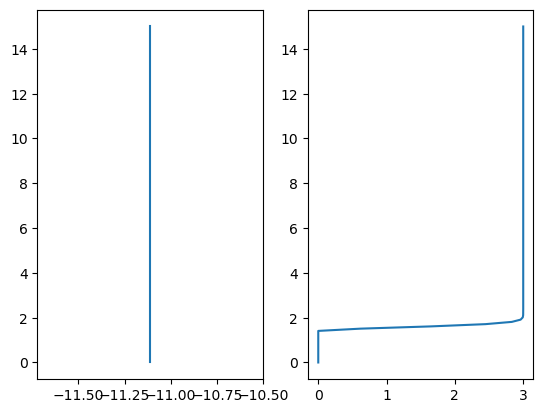

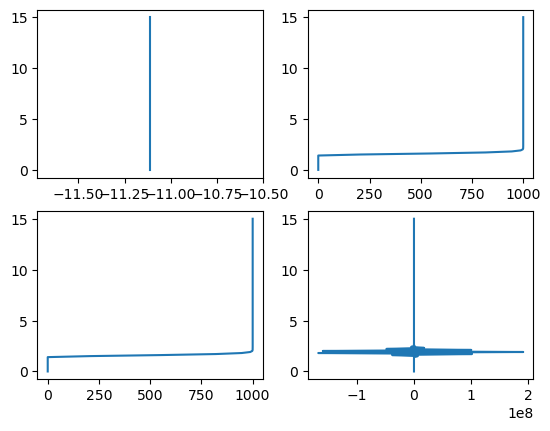

In [40]:
workspace_plots(resol_test(t_0,t_f,dt,dz,-1,workspace,q_parameters))